In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import train_test_split
import math
%matplotlib inline

In [85]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [86]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [87]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [88]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)

X_train, X_test, Y_train, Y_test \
= train_test_split((train_data['data'] - np.mean(train_data['data']))/ (np.std(train_data['data']) + 10 ** (-2)),\
                   train_data['target'], test_size = 0.15, random_state=10)

y_test_hot = np.array(list(map(lambda y : encoder.transform(y), Y_test)))
y_train_hot = np.array(list(map(lambda y : encoder.transform(y), Y_train)))


X_test_norm = (test_data['data'] - np.mean(train_data['data']))/ (np.std(train_data['data']) + 10 ** (-2))
#нормируем по тренировочной

In [89]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [90]:
class Softmax:
    
    def forward(self, x):
        self.x = np.exp(x)/np.sum(np.exp(x))
        return self.x 
    
    def backward(self, dz, lr=0.00001):
        g = np.multiply((np.eye(self.x.shape[0], self.x.shape[0])-self.x).T, self.x)
        return np.dot(dz, g)

In [91]:
x = np.array([0.001, -0.001])
s = Softmax()
sm = s.forward(x)
print(sm)

dz = np.array([0, -2.])
print('dz', s.backward(dz))

[0.5005 0.4995]
dz [ 0.4999995 -0.4999995]


In [92]:
class ReLU:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [93]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.dot(y_true, np.log(y_hat))

    def backward(self, dz, lr=0.00001):
        return -dz*self.y_true/self.y_hat

In [94]:
loss = CrossEntropy()
a = np.array([1, 2])
b = np.array([3, 4])
g = loss.forward(a, b)
g
c = loss.backward(np.array([5, 6]))
c

array([-1.66666667, -3.        ])

In [95]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [96]:
class MnistNet:
    
    def __init__(self, rlambda=0.0001):
        self.d1 = Dense(784, 150, rlambda)
        #self.do = Dropout()
        self.m = ReLU()
        self.d2 = Dense(150, 10, rlambda)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        #net = self.do.forward(net)
        net = self.m.forward(net)
        net = self.d2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m.backward(dz, lr)
        #dz = self.do.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

In [97]:
net = MnistNet(0.0001)
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []
A_train = []
A_test = []

for iter in range(10):
    L_acc = 0.
    sh = list(range(X_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = y_train_hot[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= y_train_hot.shape[0]
    L_train.append(L_acc)
    A_train.append(compute_acc(X_train, Y_train, net))
    L_e_acc = 0.
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = y_test_hot[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_e_acc += L
    L_e_acc /= y_test_hot.shape[0]
    L_test.append(L_e_acc)
    A_test.append(compute_acc(X_test, Y_test, net))
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))

0 iter loss. Train : 0.27928823292189553 . Test : 0.16537723092486825
1 iter loss. Train : 0.13519630852702644 . Test : 0.12645331805550586
2 iter loss. Train : 0.09702629229706494 . Test : 0.10976940268566535
3 iter loss. Train : 0.07510382631477655 . Test : 0.09975964114243693
4 iter loss. Train : 0.06019570575257211 . Test : 0.09449330023795445
5 iter loss. Train : 0.05004182067915679 . Test : 0.09768325401917802
6 iter loss. Train : 0.04160407294150519 . Test : 0.08270683935230601
7 iter loss. Train : 0.035467353912313274 . Test : 0.08682628987553104
8 iter loss. Train : 0.02980996789185543 . Test : 0.08430202494363682
9 iter loss. Train : 0.025777705794741413 . Test : 0.08169040319179352


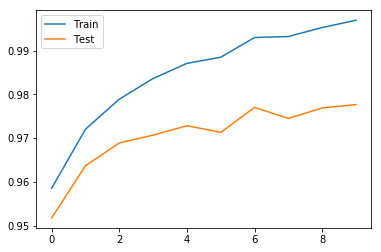

In [98]:
plt.plot(A_train, label='Train')#рисуем акураси
plt.plot(A_test, label='Test')
plt.legend()

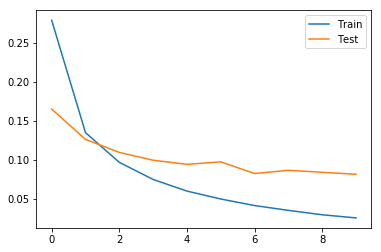

In [99]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label='Train')
plt.plot(L_test, label='Test')
plt.legend()

In [100]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test_norm, net)